## Exploratory Analysis of Monthly Retail Sales Data 


### Import

In [2]:
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Import DataSet

In [15]:
sales = pd.read_csv('dataset.csv', parse_dates=['Date'])
sales

,Date,Sales,Advertising,Footfall
0,2015-01-01,205,25,310
1,2015-02-01,208,24,312
2,2015-03-01,212,26,315
3,2015-04-01,220,27,318
4,2015-05-01,230,28,322
...,...,...,...,...
103,2023-08-01,445,53,460
104,2023-09-01,470,57,480
105,2023-10-01,505,68,520
106,2023-11-01,550,75,560


In [16]:
sales.set_index('Date', inplace=True)
sales

,Sales,Advertising,Footfall
Date,,,
2015-01-01,205,25,310
2015-02-01,208,24,312
2015-03-01,212,26,315
2015-04-01,220,27,318
2015-05-01,230,28,322
...,...,...,...
2023-08-01,445,53,460
2023-09-01,470,57,480
2023-10-01,505,68,520


In [17]:
sales.index = pd.to_datetime(sales.index)  # ensure proper datetime index

sales

# "2024-01-01" (string) → 2024-01-01 00:00:00 (proper datetime64[ns] object).

,Sales,Advertising,Footfall
Date,,,
2015-01-01,205,25,310
2015-02-01,208,24,312
2015-03-01,212,26,315
2015-04-01,220,27,318
2015-05-01,230,28,322
...,...,...,...
2023-08-01,445,53,460
2023-09-01,470,57,480
2023-10-01,505,68,520


#### STEP 1: Visualize time series (line plot) and box plots by month/year

##### LinePlot

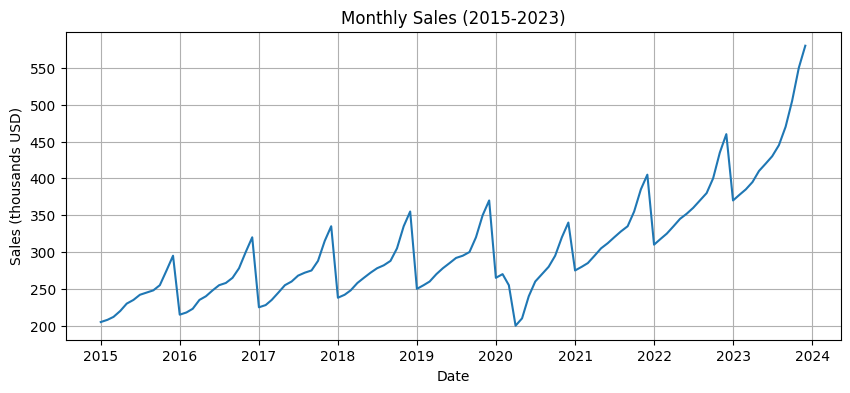

In [18]:
plt.figure(figsize=(10,4))
plt.plot(sales.index, sales['Sales'])
plt.title('Monthly Sales (2015-2023)')
plt.xlabel('Date')
plt.ylabel('Sales (thousands USD)')
plt.grid(True)
plt.show()

##### Box plot by month

C:\Users\Abhii\AppData\Local\Temp\ipykernel_21848\746174469.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sales[sales['Month']==m]['Sales'].values for m in range(1,13)], labels=list(range(1,13)))


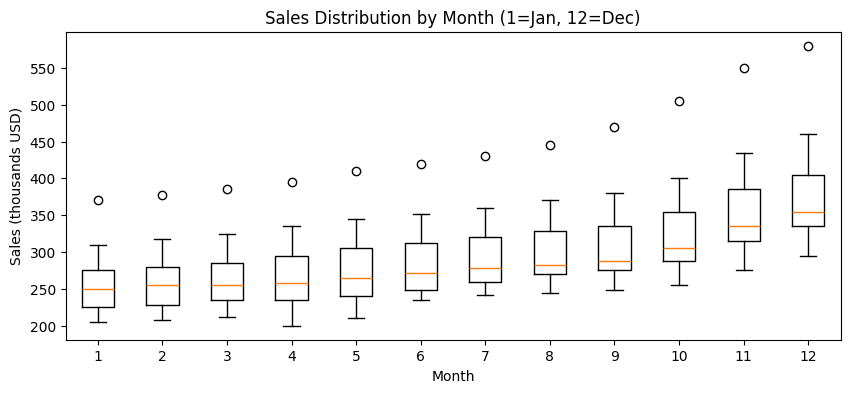

In [20]:
sales['Month'] = sales.index.month
plt.figure(figsize=(10,4))
plt.boxplot([sales[sales['Month']==m]['Sales'].values for m in range(1,13)], labels=list(range(1,13)))
plt.title('Sales Distribution by Month (1=Jan, 12=Dec)')
plt.xlabel('Month')
plt.ylabel('Sales (thousands USD)')
plt.show()

##### Box plot by year

C:\Users\Abhii\AppData\Local\Temp\ipykernel_21848\2675301394.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sales[sales['Year']==y]['Sales'].values for y in years], labels=years)


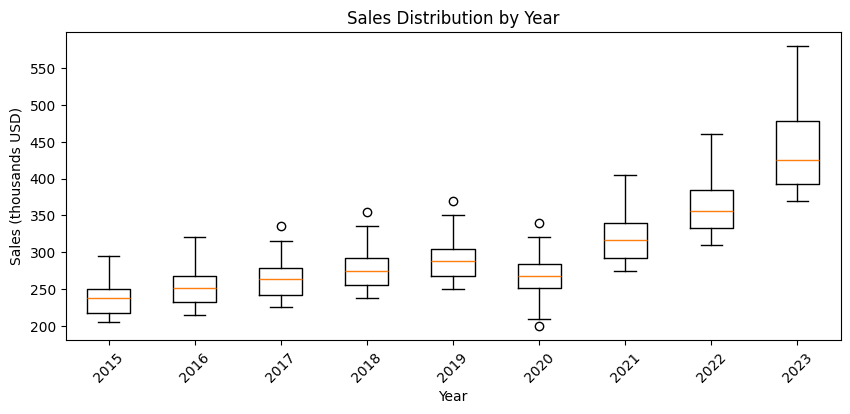

In [21]:
sales['Year'] = sales.index.year
years = sorted(sales['Year'].unique())
plt.figure(figsize=(10,4))
plt.boxplot([sales[sales['Year']==y]['Sales'].values for y in years], labels=years)
plt.title('Sales Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Sales (thousands USD)')
plt.xticks(rotation=45)
plt.show()

### Interpretation Goals : 

    1. When Do Sales Usually Peak?
    Ans : At the End Of The Years

    2. Is There A Clear LongTerm Increase?
    Ans :  Yes

    3. Are There Any Outlier Month or years?
    Ans : 2020

#### STEP 2: Spotting patterns - rolling mean to highlight trend

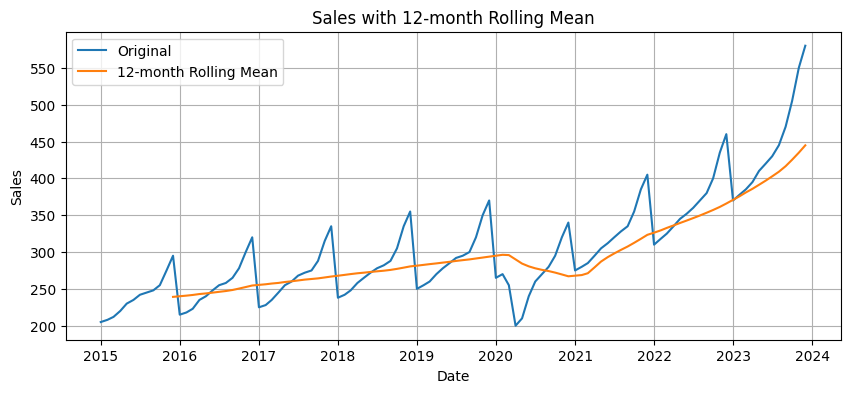

In [24]:
sales['RollingMean_12'] = sales['Sales'].rolling(window=12).mean()

# Rolling Mean Is Average of Sales Of All Mnths In Particular Year


plt.figure(figsize=(10,4))
plt.plot(sales.index, sales['Sales'], label='Original')
plt.plot(sales.index, sales['RollingMean_12'], label='12-month Rolling Mean')
plt.title('Sales with 12-month Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### Interpretation Goals:
    1. What patterns repeat every year?
    Ans: Seasonal
    2.Is the trend linear, curved, or fluctuating?
    Ans: Fluctuating
    3.Are there unusual months that don’t follow the pattern?
    Ans: Nov and Dec


#### STEP 3: Decomposition (additive) - period=12 for monthly data

##### Decompose the series using an additive model.


In [27]:
decomp = seasonal_decompose(sales['Sales'], model='additive', period=12)

##### 	Visually display each component:

- Observed Series = Trend + Seasonal + Residual.

- Trend = long-term direction.

- Seasonal = repeating cycles.

- Residual = randomness / outliers.

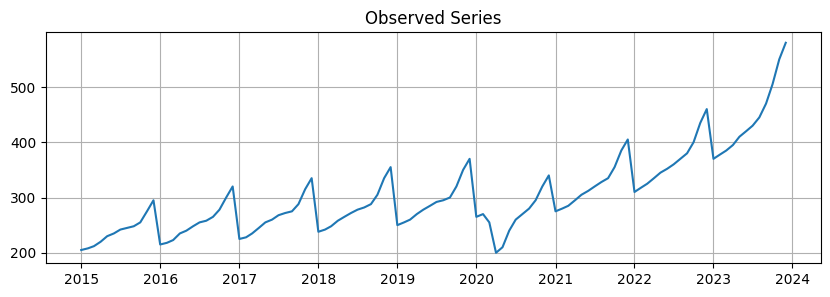

In [28]:
plt.figure(figsize=(10,3))
plt.plot(sales.index, sales['Sales'])
plt.title('Observed Series')
plt.grid(True)
plt.show()


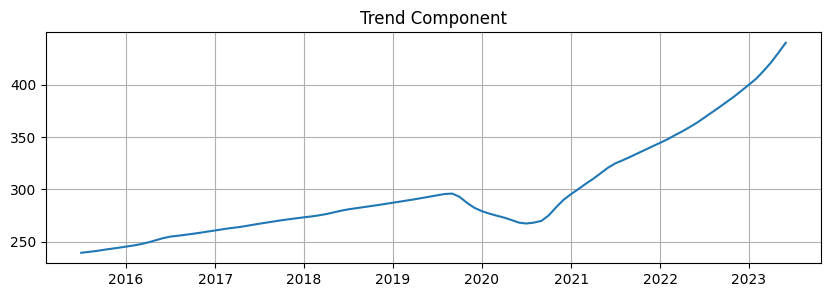

In [29]:
# Trend component (general movement)

plt.figure(figsize=(10,3))
plt.plot(sales.index, decomp.trend)
plt.title('Trend Component')
plt.grid(True)
plt.show()

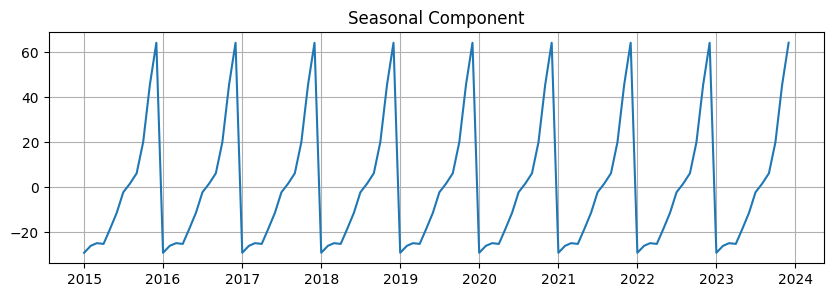

In [31]:
# 	Seasonal component (regular fluctuations)

plt.figure(figsize=(10,3))
plt.plot(sales.index, decomp.seasonal)
plt.title('Seasonal Component')
plt.grid(True)
plt.show()

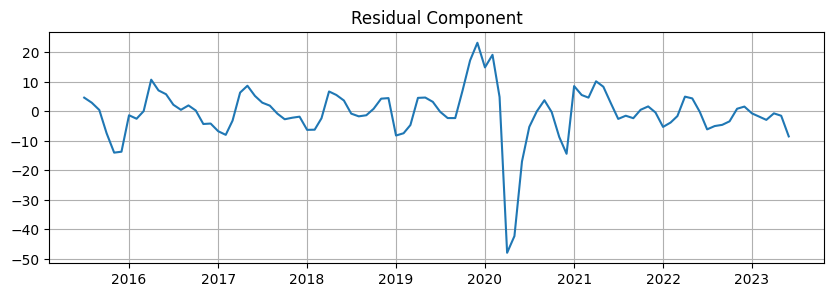

In [32]:
# Residual component (random variation)

plt.figure(figsize=(10,3))
plt.plot(sales.index, decomp.resid)
plt.title('Residual Component')
plt.grid(True)
plt.show()

#### Interpretation Goals:
    1. What is the underlying trend?
    Ans: Increasing
    2. How strong is the seasonal pattern?
    Ans:Repeating every year
    3. Does the residual look random (i.e., no visible pattern)?
    Ans:Random


#### Step 4: Smoothing the Data — Moving Average

- To remove random short-term noise and highlight long-term movement.

##### Apply moving averages using different window sizes (3, 6, and 12 months).

In [ ]:
sales['SMA_3'] = sales['Sales'].rolling(window=3).mean()  # SMA_3: average of the last 3 months
sales['SMA_6'] = sales['Sales'].rolling(window=6).mean()
sales['SMA_12'] = sales['Sales'].rolling(window=12).mean()

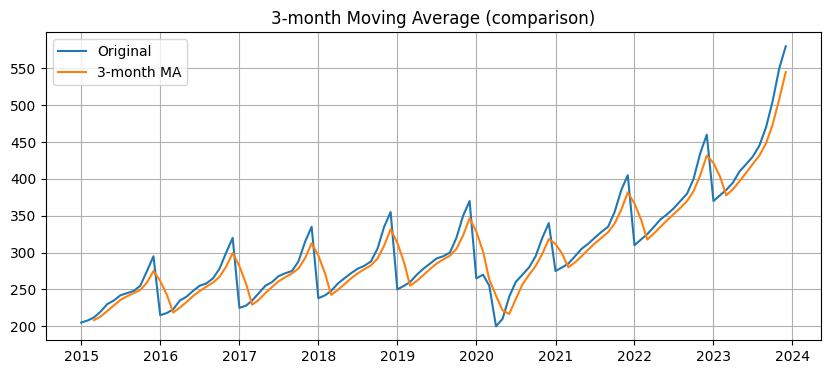

In [34]:
plt.figure(figsize=(10,4))
plt.plot(sales.index, sales['Sales'], label='Original')
plt.plot(sales.index, sales['SMA_3'], label='3-month MA')
plt.title('3-month Moving Average (comparison)')
plt.legend()
plt.grid(True)
plt.show()

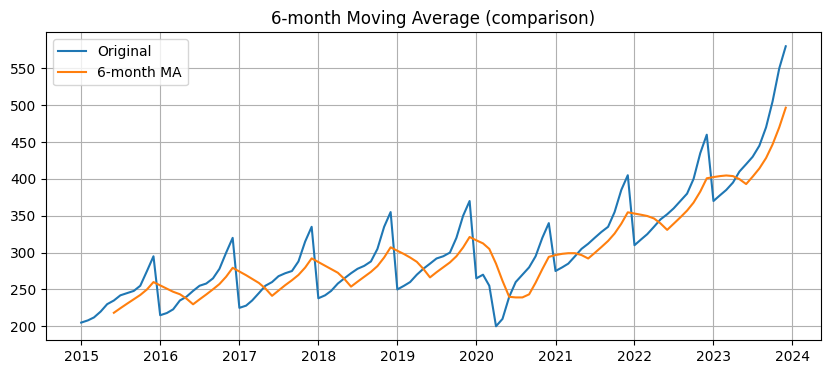

In [35]:
plt.figure(figsize=(10,4))
plt.plot(sales.index, sales['Sales'], label='Original')
plt.plot(sales.index, sales['SMA_6'], label='6-month MA')
plt.title('6-month Moving Average (comparison)')
plt.legend()
plt.grid(True)
plt.show()

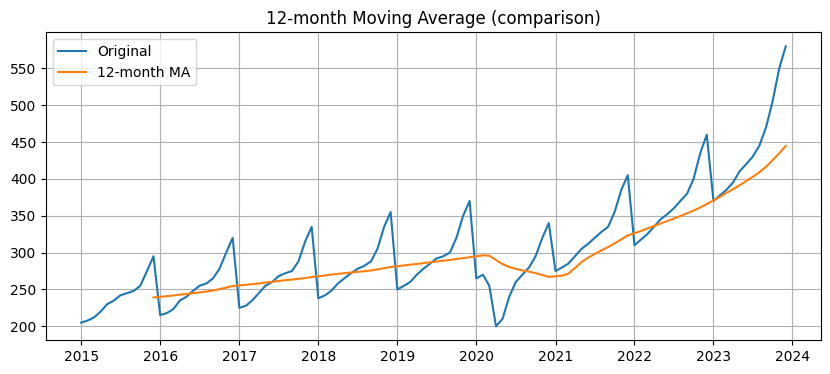

In [37]:
plt.figure(figsize=(10,4))
plt.plot(sales.index, sales['Sales'], label='Original')
plt.plot(sales.index, sales['SMA_12'], label='12-month MA')
plt.title('12-month Moving Average (comparison)')
plt.legend()
plt.grid(True)
plt.show()

#### Interpretation Goals:
    1. Which window length best reveals the trend?
    Ans: 12
    2. What happens when the window is too short or too long?
    Ans: Short : Sensitive , Long : Shows true trend , but Rendering Is Slow
    3. What long-term changes in sales become visible after smoothing?
    Ans: Upward Trend


#### Step 5: Smoothing the Data — Exponential Smoothing

##### Apply exponential smoothing with different smoothing factors (e.g., 0.2, 0.5, 0.8).

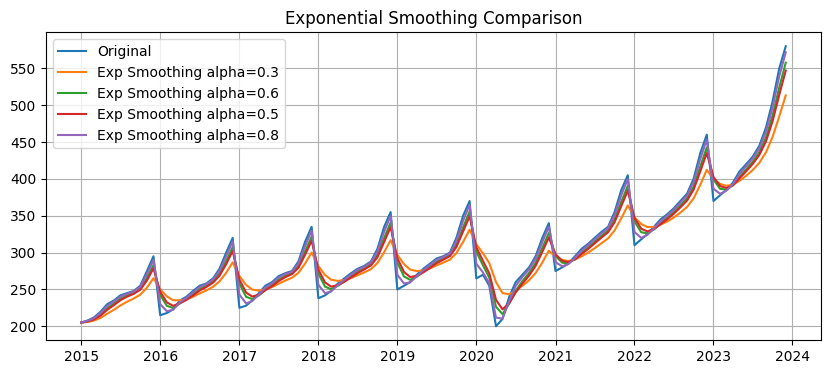

In [40]:
sales['ES_alpha_0.3'] = sales['Sales'].ewm(alpha=0.3, adjust=False).mean()
sales['ES_alpha_0.6'] = sales['Sales'].ewm(alpha=0.6, adjust=False).mean()
sales['ES_alpha_0.5'] = sales['Sales'].ewm(alpha=0.5, adjust=False).mean()
sales['ES_alpha_0.8'] = sales['Sales'].ewm(alpha=0.8, adjust=False).mean()

plt.figure(figsize=(10,4))
plt.plot(sales.index, sales['Sales'], label='Original')
plt.plot(sales.index, sales['ES_alpha_0.3'], label='Exp Smoothing alpha=0.3')
plt.plot(sales.index, sales['ES_alpha_0.6'], label='Exp Smoothing alpha=0.6')
plt.plot(sales.index, sales['ES_alpha_0.5'], label='Exp Smoothing alpha=0.5')
plt.plot(sales.index, sales['ES_alpha_0.8'], label='Exp Smoothing alpha=0.8')

plt.title('Exponential Smoothing Comparison')
plt.legend()
plt.grid(True)
plt.show()

#### Interpretation Goals:
    1. How does exponential smoothing respond to new changes?
    Ans: alpha = 0.3 : smoother line , alpha = 0.6 : sudden raise and drops
    2. Does it capture shifts in recent months more effectively than the moving average?
    Ans: Yes
    3. What value of alpha seems most appropriate for this dataset?
    Ans: 


#### Step 6: Checking for Stationarity

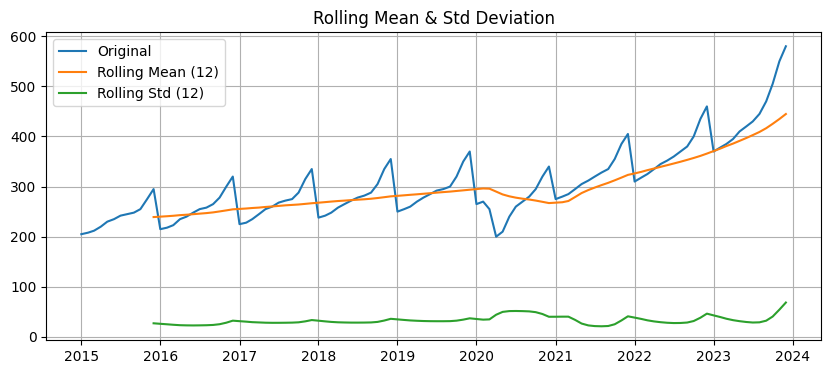

In [39]:
roll_mean = sales['Sales'].rolling(window=12).mean()
roll_std = sales['Sales'].rolling(window=12).std()

plt.figure(figsize=(10,4))
plt.plot(sales.index, sales['Sales'], label='Original')
plt.plot(sales.index, roll_mean, label='Rolling Mean (12)')
plt.plot(sales.index, roll_std, label='Rolling Std (12)')
plt.title('Rolling Mean & Std Deviation')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Augmented Dickey-Fuller test
adf_result = adfuller(sales['Sales'])
print("ADF Statistic (original): {:.4f}".format(adf_result[0]))
print("p-value (original): {:.4f}".format(adf_result[1]))
for key, val in adf_result[4].items():
    print("Critical Value ({}): {:.4f}".format(key, val))

ADF Statistic (original): 2.0876
p-value (original): 0.9988
Critical Value (1%): -3.5019
Critical Value (5%): -2.8928
Critical Value (10%): -2.5835


#### Interpretation Goals:
    1. Is the original data stationary?
    Ans: 
    2. If not, what feature (trend or seasonality) makes it non-stationary?
    Ans: 
    3. Why is stationarity important for further analysis?
    Ans: 


#### Step 7: Differencing the Series

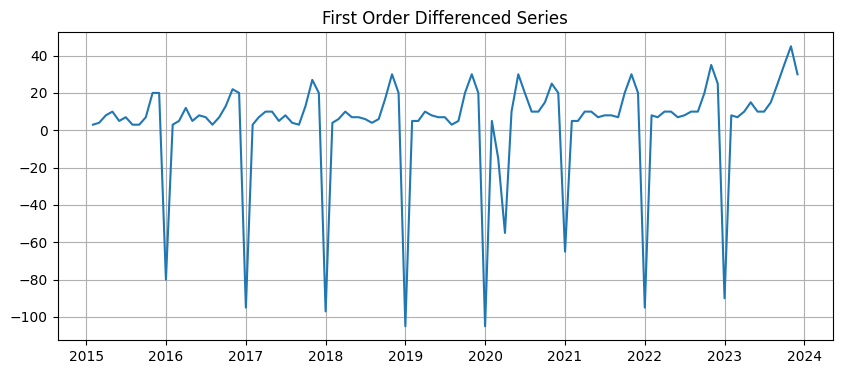

ADF Statistic (1st diff): -0.8601
p-value (1st diff): 0.8008


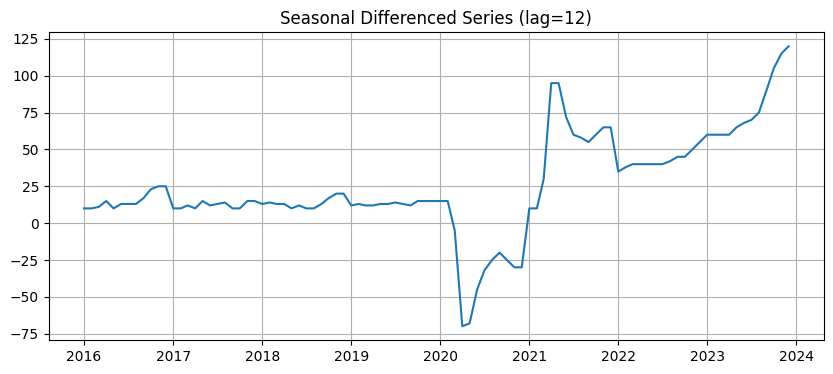

ADF Statistic (seasonal diff): 0.2262
p-value (seasonal diff): 0.9737


In [43]:
sales['FirstDiff'] = sales['Sales'].diff()
plt.figure(figsize=(10,4))
plt.plot(sales.index, sales['FirstDiff'])
plt.title('First Order Differenced Series')
plt.grid(True)
plt.show()

adf_fd = adfuller(sales['FirstDiff'].dropna())
print("ADF Statistic (1st diff): {:.4f}".format(adf_fd[0]))
print("p-value (1st diff): {:.4f}".format(adf_fd[1]))

sales['SeasonalDiff'] = sales['Sales'].diff(12)
plt.figure(figsize=(10,4))
plt.plot(sales.index, sales['SeasonalDiff'])
plt.title('Seasonal Differenced Series (lag=12)')
plt.grid(True)
plt.show()

adf_sd = adfuller(sales['SeasonalDiff'].dropna())
print("ADF Statistic (seasonal diff): {:.4f}".format(adf_sd[0]))
print("p-value (seasonal diff): {:.4f}".format(adf_sd[1]))

#### Interpretation Goals:
    1. Does differencing remove the upward trend?
    Ans: Yes
    2. Are the differences now centered around zero?
    Ans: Yes
    3. Does the variance look more stable after differencing?
    Ans: Yes